# Graph-based Pattern Representations Tutorial

#### Easy Reading: [nbviewer](https://nbviewer.jupyter.org/github/IDEA-NTHU-Taiwan/PatternTutorial/blob/master/Graph-based%20Pattern%20Representations%20Tutorial.ipynb)

#### GitHub Repo: [IDEA-NTHU-Taiwan/PatternTutorial](https://github.com/IDEA-NTHU-Taiwan/PatternTutorial)

#### Example Dataset: [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

#### Author: [Ray](https://github.com/thisray), [Evan](https://github.com/EvanYu800112)

#### Libraries requirements
`matplotlib`, `networkx`, `nltk`, `numpy`, `pandas`, `IDEAlib` (in this repo)

#### References

Argueta Carlos, Elvis Saravia, and Yi-Shin Chen. "Unsupervised graph-based patterns extraction for emotion classification." In 2015 IEEE/ACM International Conference on Advances in Social Networks Analysis and Mining (ASONAM), pp. 336-341. IEEE, 2015.

Saravia Elvis, Carlos Argueta, and Yi-Shin Chen. "Unsupervised graph-based pattern extraction for multilingual emotion classification." Social Network Analysis and Mining 6, no. 1 (2016): 92.

Saravia Elvis, Hsien-Chi Toby Liu, Yen-Hao Huang, Junlin Wu, and Yi-Shin Chen. "CARER: Contextualized Affect Representations for Emotion Recognition." In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, pp. 3687-3697. 2018.

In [1]:
import matplotlib
%matplotlib inline

---
## Basic Framework

<img src="./img/0_framework.png" width="600" align="left">

---
### Jupyter notebook setting

In [2]:
%load_ext autoreload
%autoreload 2

class display_df(object):
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

---
## Load data

In [3]:
import IDEAlib as idea
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_colwidth', 100)
np.random.seed(9527)

data_path_sub = './data/train.pkl'
pattern_dir = './pattern_dir'

text_col = 'text'
label_col = 'emotion'

if not os.path.isdir(pattern_dir):
    os.mkdir(pattern_dir)

df_train = pd.read_pickle(data_path_sub)
col_list = [label_col, text_col]
df_train = df_train[col_list]

df_train.head()

emotion  \
1704     fear   
1152     fear   
1038     fear   
3497  sadness   
1940     fear   

                                                                                                     text  
1704  @realDonaldTrump @KellyannePolls New campaign slogan idea...'I know you are but what am I?'  #Tr...  
1152  We in our own country are so divided in our approach so how could we fight #terrorism and #pakis...  
1038  @twlldun @bbcquestiontime @JacobReesMogg @leicesterliz @normanlamb @CarolineLucas @JuliaHB1 Oh g...  
3497                               #PeopleLikeMeBecause of some unknown reason but I try to discourage it  
1940                                       @BigDaddyx47 awe I'm sorry! I have 2 dogs 3 cats &amp; a snake

## Preprocessing

Finish all the preprocessing tasks here (e.g. tokenize, segmentation, replace something...)

In [4]:
import nltk

tokenizer = nltk.tokenize.TweetTokenizer()

# preprocessing function
def my_preprocess(text):
    text = idea.utils.tweet_replaceToken(text)
    text = tokenizer.tokenize(text)
    return text

# define column name
token_column = 'tokenized_text'

# preprocess
df_train[token_column] = df_train[text_col].apply(lambda text: my_preprocess(text))

df_train.head()

emotion  \
1704     fear   
1152     fear   
1038     fear   
3497  sadness   
1940     fear   

                                                                                                     text  \
1704  @realDonaldTrump @KellyannePolls New campaign slogan idea...'I know you are but what am I?'  #Tr...   
1152  We in our own country are so divided in our approach so how could we fight #terrorism and #pakis...   
1038  @twlldun @bbcquestiontime @JacobReesMogg @leicesterliz @normanlamb @CarolineLucas @JuliaHB1 Oh g...   
3497                               #PeopleLikeMeBecause of some unknown reason but I try to discourage it   
1940                                       @BigDaddyx47 awe I'm sorry! I have 2 dogs 3 cats &amp; a snake   

                                                                                           tokenized_text  
1704  [<M>, <M>, new, campaign, slogan, idea, ..., ', i, know, you, are, but, what, am, i, ?, ', <H>, ...  
1152  [we, in, our, own, country, are, so, divided, in, our, approach, so, how, could, we, fight, <H>,...  
1038  [<M>, <M>, <M>, <M>, <M>, <M>, <M>, oh, god, ,, not, brewer, again, ., the, horror, ,, the, horror]  
3497                                    [<H>, of, some, unknown, reason, but, i, try, to, discourage, it]  
1940                                    [<M>, awe, i'm, sorry, !, i, have, 2, dogs, 3, cats, &, a, snake]

---
## 1. Graph construction

<img src="./img/1_GC.png" width="860">        
<br>

Using the neighbor (bi-gram) relationship between tokens in all texts to construct a undirected weighted graph   

* example: `how do you turn this on` $\rightarrow$ (`how - do`), (`do - you`), (`you - turn`), (`turn - this`), (`this - on`)     
 
The weights in graph are calculate by frequency:
<img src="./img/1_eq.png" width="200">       

* construct: `idea.graph.ngramGraph()`    
* visualize: `idea.graph.show()`

#### Note:
1. The weight and normalize methods are user-defined.
2. The graph operation of our `idea.graph` library is based on `networkx` python library ([https://github.com/networkx/networkx](https://github.com/networkx/networkx)).   
    There is another efficient graph software `Gephi` ([https://gephi.org/](https://gephi.org/)) you can try.
    

In [5]:
# input form: array or list
tokenized_text = df_train[token_column].values

# construct graph
graph_sub = idea.graph.ngramGraph(texts=tokenized_text, gram_n=2, 
                                  space_token='_space_', max_norm=True, 
                                  take_ratio=1.0, freq_threshold=3)


Graph constructed from (3613) sentences, there are (1012) nodes(tokens) in this graph.


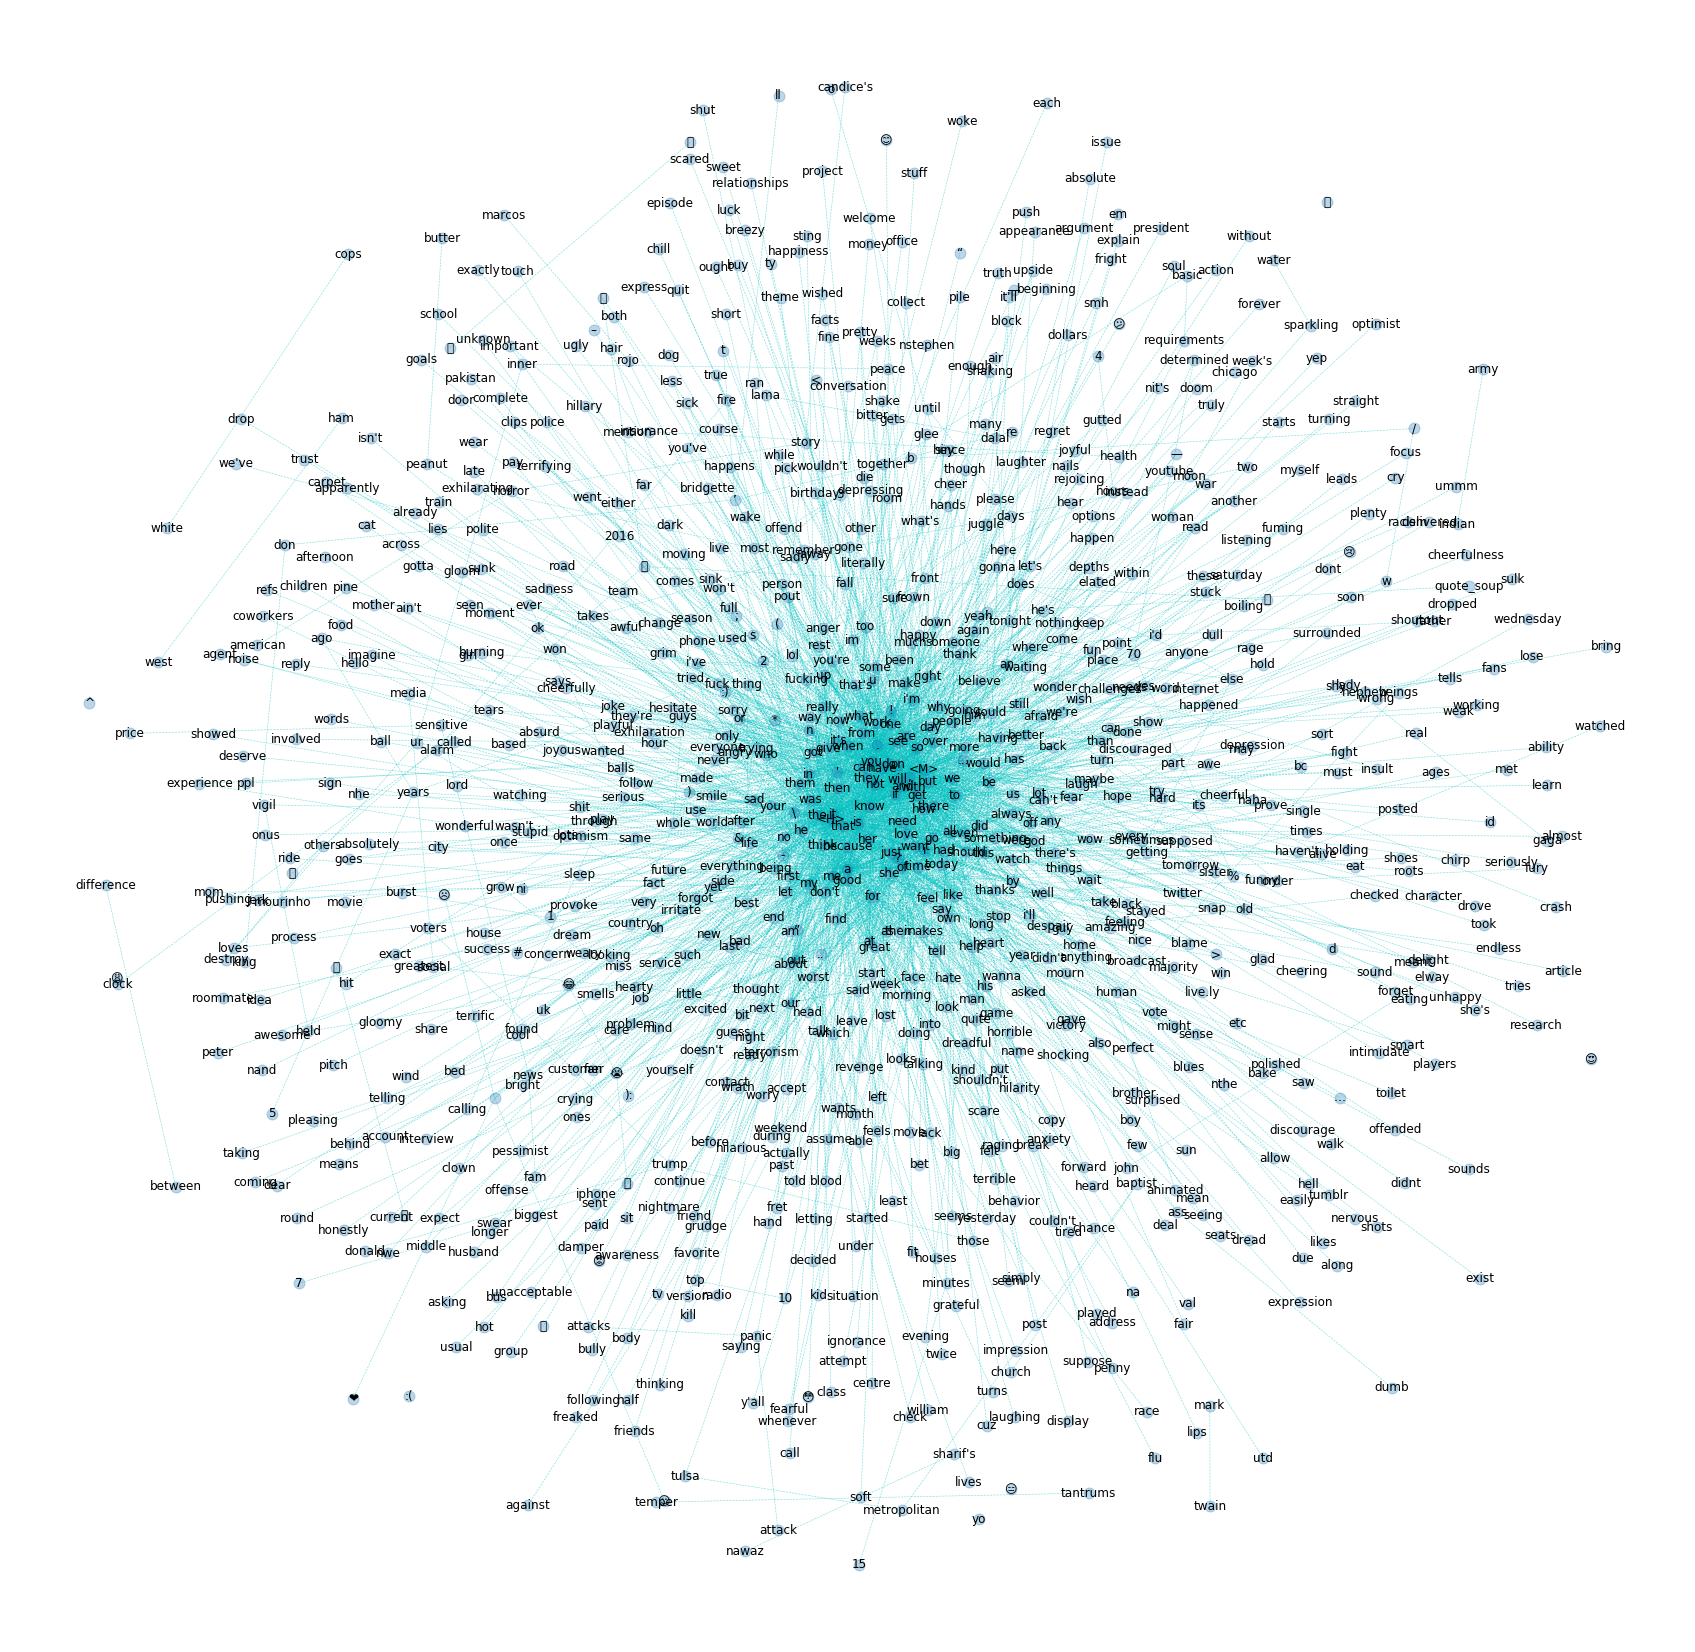

In [6]:
# graph visualization
idea.graph.show(graph_sub)

Here I skip the `graph aggregation` part (graph_emo = graph_sub - graph_obj), it can be operated by `idea.graph.minus()`

In [7]:
# graph_emo = graph_utils.graph_minus(graph_sub, graph_obj)

# Using the same graph to extract patterns.
graph_emo = graph_sub

---
## 2. Token Categorization (CW, SW)

<br>
<img src="./img/2_TC.png" width="860">

Determine the `Connector words` and `Subject words` by `eigenvector centrality` and `clustering coeffcient` respectively.     
(by `idea.graph.eigenvector_centrality()` & `idea.graph.clustering_coefficitnt()`)

In [8]:
# input: graph
df_ec = idea.graph.eigenvector_centrality(graph_emo, show_time=True)
df_cc = idea.graph.clustering_coefficient(graph_emo, show_time=True)

print('eigenvector centrality, clustering coeffcient')
display_df('df_ec.head(10)', 'df_cc.head(10)')

eigenvector centrality cost: 0.0923 sec
clustering coefficient cost: 0.1222 sec
eigenvector centrality, clustering coeffcient


df_ec.head(10)
   token     value
2      .  0.256881
0    <H>  0.220465
1    <M>  0.220353
8    the  0.219442
15     ,  0.204646
32     a  0.176782
10    to  0.171004
25    is  0.155122
6      i  0.153904
61  that  0.152587

df_cc.head(10)
        token  value
350     mourn    1.0
585  horrible    1.0
978        ):    1.0
975    within    1.0
252      he's    1.0
254     which    1.0
255  happened    1.0
602     blood    1.0
262      pick    1.0
973        uk    1.0

In [9]:
# filtered with triangles
# the difference would be demoed below

df_cc_filtered = idea.graph.clustering_coefficient(graph_emo, show_time=True, triangle_threshold=1)

clustering coefficient cost: 0.4557 sec


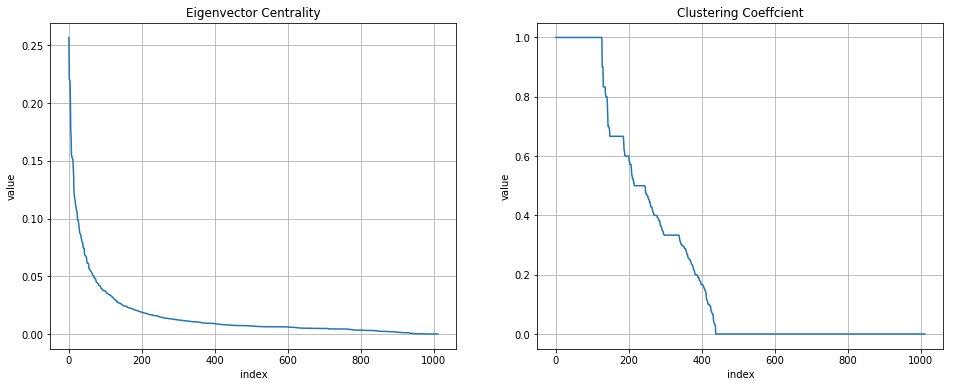

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualization
plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(df_ec['value'].values)
plt.title('Eigenvector Centrality')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_cc['value'].values)
plt.title('Clustering Coeffcient')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.show()

###  Clustering Coefficient Difference for Triangles Filtering Step



We could see that the filtering process with triangle reduces the numbers of word with cluster coefficient value 1


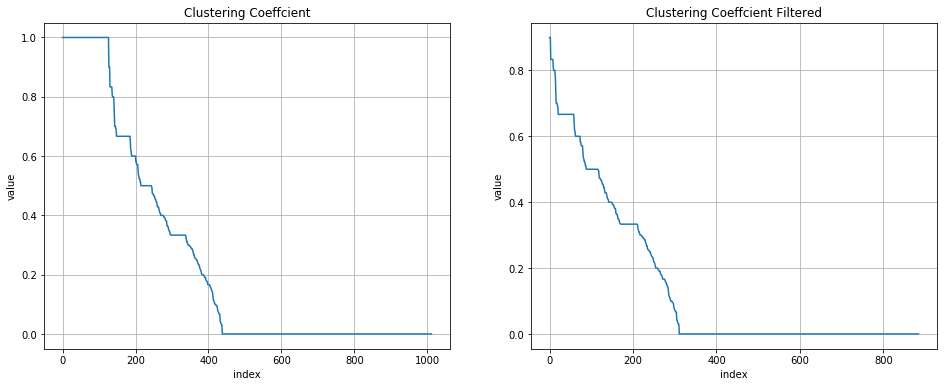

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualization
plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(df_cc['value'].values)
plt.title('Clustering Coeffcient')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_cc_filtered['value'].values)
plt.title('Clustering Coeffcient Filtered')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

print('\n\nWe could see that the filtering process with triangle reduces the numbers of word with cluster coefficient value 1')

plt.show()

### Decide the threshold for CW & SW
User-definded threshold (`threshold_ec`, `threshold_cc`)

In [12]:
# hint: using frequency to help us decide `threshold_cc`.
df_cc['value'].value_counts().head(8)

0.000000    574
1.000000    127
0.333333     41
0.666667     38
0.500000     29
0.600000     11
0.400000      8
0.833333      6
Name: value, dtype: int64

In [13]:
# ec for CW, cc for SW
threshold_ec = 0.025
threshold_cc = 0.33

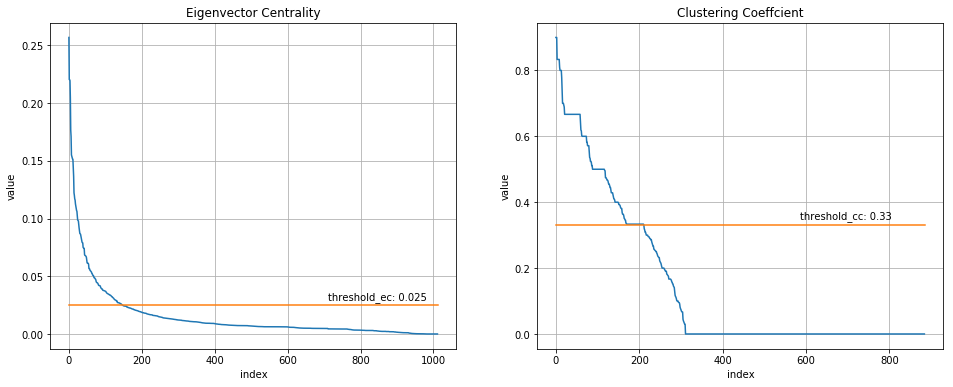

In [14]:
# visualize again
plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(df_ec['value'].values)
plt.plot([0, len(df_ec)], [threshold_ec, threshold_ec], linestyle='solid')
plt.text(len(df_ec)-300, threshold_ec+0.005, 'threshold_ec: {}'.format(threshold_ec))
plt.title('Eigenvector Centrality')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_cc_filtered['value'].values)
plt.plot([0, len(df_cc_filtered)], [threshold_cc, threshold_cc], linestyle='solid')
plt.text(len(df_cc_filtered)-300, threshold_cc+0.02, 'threshold_cc: {}'.format(threshold_cc))
plt.title('Clustering Coeffcient')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.show()

### Obtain CW list & SW list

Based on the thresholds, we obtain the `CW_list` and `SW_list`. (by `idea.pattern.listcwsw()`)

In [15]:
CW_list = idea.pattern.listcwsw(df=df_ec, threshold=threshold_ec)
SW_list = idea.pattern.listcwsw(df=df_cc, threshold=threshold_cc)

print('CW_list: ', CW_list[:8], ' ...')
print('SW_list: ', SW_list[:8], ' ...')

CW_list:  ['.' '<H>' '<M>' 'the' ',' 'a' 'to' 'is']  ...
SW_list:  ['mourn' 'horrible' '):' 'within' "he's" 'which' 'happened' 'blood']  ...


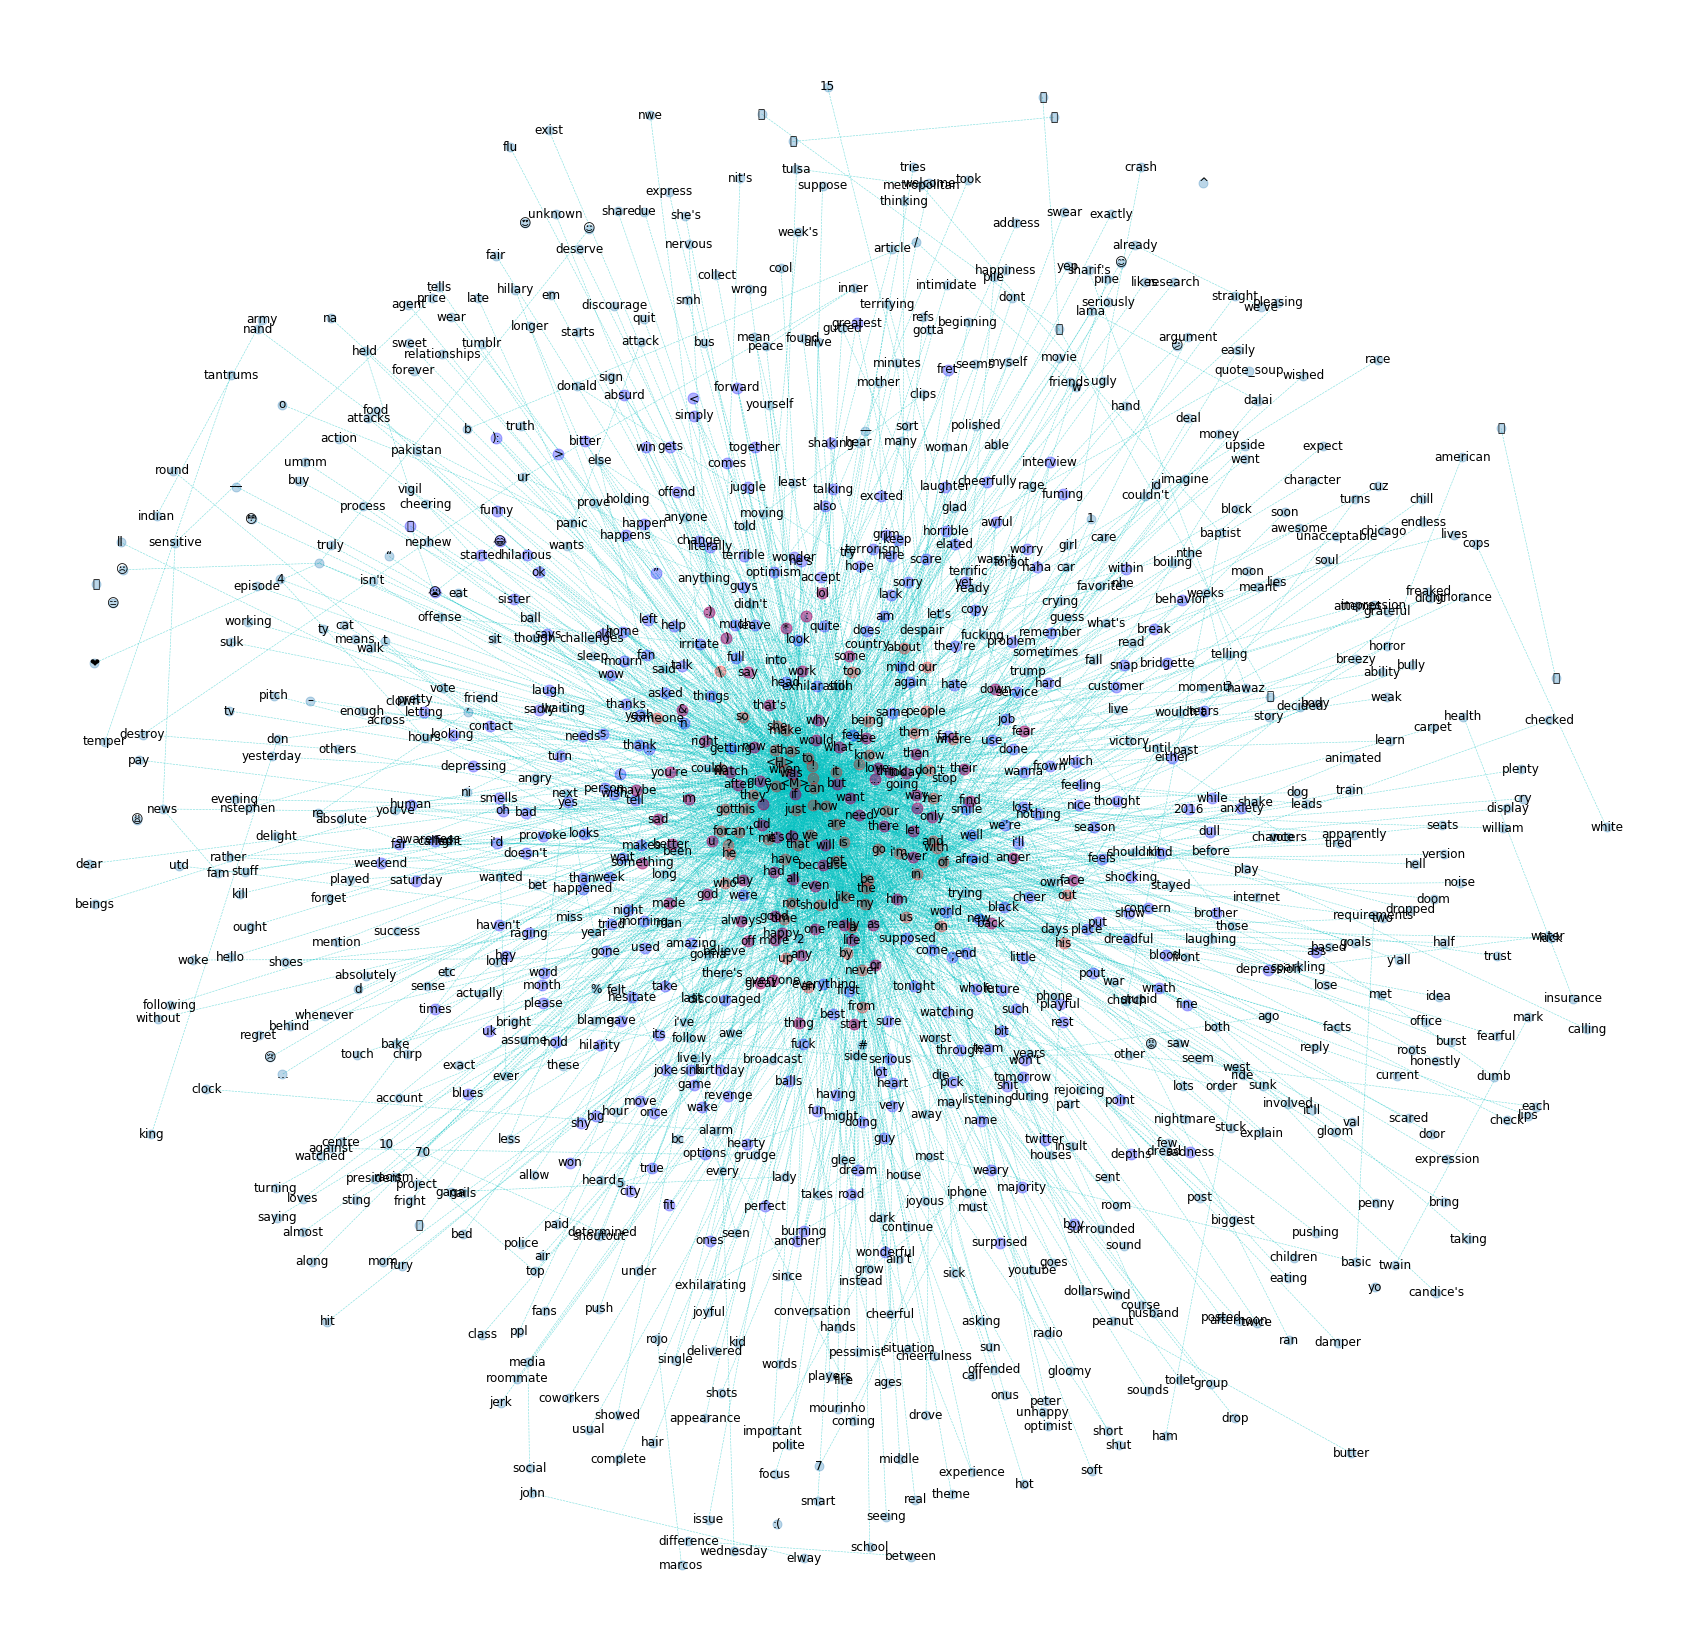

In [16]:
## visualize cw sw
"""
orange: cw
blue: sw
purple: both
"""
idea.graph.show_cwsw(graph_emo, list(CW_list), list(SW_list))

In [17]:
# save
cw_file = os.path.join(pattern_dir, 'CW_list.npy')
sw_file = os.path.join(pattern_dir, 'SW_list.npy')

np.save(cw_file, CW_list)
np.save(sw_file, SW_list)
print('save ok\n {}\n {}'.format(cw_file, sw_file))

# load
# CW_list = np.load(cw_file)
# SW_list = np.load(sw_file)

save ok
 ./pattern_dir/CW_list.npy
 ./pattern_dir/SW_list.npy


---
## 3. Pattern extraction
<br>
<img src="./img/3_example_.png" width="600">

### Convert tokens to CW SW

Convert `tokenized_text` column into cwsw type. (by apply `idea.pattern.token2cwsw()`)

In [18]:
# define column name & token name
cwsw_column = 'cwsw_text'
cw_token = 'cw'
sw_token = 'sw'
none_token = '_'
both_token = 'both'

# multi-processing
multi = idea.utils.apply_by_multiprocessing

# token2cwsw
df_train[cwsw_column] = multi(df=df_train[token_column], func=idea.pattern.token2cwsw, 
                              cw_list=CW_list, sw_list=SW_list, cw_token=cw_token, sw_token=sw_token, 
                              none_token=none_token, both_token=both_token, workers=-1)

df_train.head()

emotion  \
1704     fear   
1152     fear   
1038     fear   
3497  sadness   
1940     fear   

                                                                                                     text  \
1704  @realDonaldTrump @KellyannePolls New campaign slogan idea...'I know you are but what am I?'  #Tr...   
1152  We in our own country are so divided in our approach so how could we fight #terrorism and #pakis...   
1038  @twlldun @bbcquestiontime @JacobReesMogg @leicesterliz @normanlamb @CarolineLucas @JuliaHB1 Oh g...   
3497                               #PeopleLikeMeBecause of some unknown reason but I try to discourage it   
1940                                       @BigDaddyx47 awe I'm sorry! I have 2 dogs 3 cats &amp; a snake   

                                                                                           tokenized_text  \
1704  [<M>, <M>, new, campaign, slogan, idea, ..., ', i, know, you, are, but, what, am, i, ?, ', <H>, ...   
1152  [we, in, our, own, country, are, so, divided, in, our, approach, so, how, could, we, fight, <H>,...   
1038  [<M>, <M>, <M>, <M>, <M>, <M>, <M>, oh, god, ,, not, brewer, again, ., the, horror, ,, the, horror]   
3497                                    [<H>, of, some, unknown, reason, but, i, try, to, discourage, it]   
1940                                    [<M>, awe, i'm, sorry, !, i, have, 2, dogs, 3, cats, &, a, snake]   

                                                                                        cwsw_text  
1704  [cw, cw, sw, _, _, _, both, both, cw, cw, cw, cw, both, both, sw, cw, cw, both, cw, cw, cw]  
1152               [cw, cw, cw, _, _, cw, cw, _, cw, cw, _, cw, cw, _, cw, _, cw, cw, cw, sw, cw]  
1038                  [cw, cw, cw, cw, cw, cw, cw, sw, both, cw, cw, _, sw, cw, cw, _, cw, cw, _]  
3497                                                 [cw, cw, both, _, _, both, cw, _, cw, _, cw]  
1940                                         [cw, _, cw, sw, cw, cw, cw, _, _, _, _, both, cw, _]

### Build pattern dictionary

Based on pre-definded `pattern_templates` and the label of this dataset to construct pattern dictionary. (by `idea.pattern.patternDict()`)    

#### Note:
1. Here we provide an argument `n_jobs` to decide multi-processing or single-processing. (default `n_jobs=-1`: using all CPU cores)
2. The rule of patterns is defined in `idea.pattern.patternDict_()`. (we don't concern the `both_token` in this version)

In [19]:
# user-defined pattern templates
pattern_templates = [['cw', 'sw'], 
                     ['cw', 'cw', 'sw'],
                     ['cw', 'sw', 'cw']]

# for check the labels
label_list = list(np.sort(np.unique(df_train[label_col].values)))
print('label_list: ', label_list)

# build pattern-dictionary (** this function is adjusted as the example below)
pattern_dict = idea.pattern.patternDict(df=df_train, label_list=label_list,
                                        pattern_templates=pattern_templates, n_jobs=-1)

label_list:  ['anger', 'fear', 'joy', 'sadness']

**Warning**: 
you are using the past (slower) version of `patternDict()`, remember to update your IDEAlib & see the new example on github


In [20]:
## new version (0509) but not finish at all

# user-defined pattern templates
pattern_templates = [['cw', 'sw'], 
                     ['cw', 'cw', 'sw'],
                     ['cw', 'sw', 'cw']]

# for check the labels
label_list = list(np.sort(np.unique(df_train[label_col].values)))
print('label_list: ', label_list)

# # build pattern-dictionary (** this function is adjusted as the example below)
# pattern_dict = idea.pattern.patternDict(df=df_train, label_list=label_list,
#                                         pattern_templates=pattern_templates, n_jobs=-1)

# define column name
patt_col = 'pattern'
patt_con_col = 'pattern_content'

# text2pattern
df_train[patt_col], df_train[patt_con_col] = multi(df_train, idea.pattern.text2pattern, 
                                                   pattern_templates=pattern_templates,
                                                   token_column=token_column, cwsw_column=cwsw_column, 
                                                   cw_token=cw_token, sw_token=sw_token, both_token=both_token, 
                                                   workers=-1, axis=1, coln=2)


label_list:  ['anger', 'fear', 'joy', 'sadness']


In [21]:
df_train.head()

emotion  \
1704     fear   
1152     fear   
1038     fear   
3497  sadness   
1940     fear   

                                                                                                     text  \
1704  @realDonaldTrump @KellyannePolls New campaign slogan idea...'I know you are but what am I?'  #Tr...   
1152  We in our own country are so divided in our approach so how could we fight #terrorism and #pakis...   
1038  @twlldun @bbcquestiontime @JacobReesMogg @leicesterliz @normanlamb @CarolineLucas @JuliaHB1 Oh g...   
3497                               #PeopleLikeMeBecause of some unknown reason but I try to discourage it   
1940                                       @BigDaddyx47 awe I'm sorry! I have 2 dogs 3 cats &amp; a snake   

                                                                                           tokenized_text  \
1704  [<M>, <M>, new, campaign, slogan, idea, ..., ', i, know, you, are, but, what, am, i, ?, ', <H>, ...   
1152  [we, in, our, own, country, are, so, divided, in, our, approach, so, how, could, we, fight, <H>,...   
1038  [<M>, <M>, <M>, <M>, <M>, <M>, <M>, oh, god, ,, not, brewer, again, ., the, horror, ,, the, horror]   
3497                                    [<H>, of, some, unknown, reason, but, i, try, to, discourage, it]   
1940                                    [<M>, awe, i'm, sorry, !, i, have, 2, dogs, 3, cats, &, a, snake]   

                                                                                        cwsw_text  \
1704  [cw, cw, sw, _, _, _, both, both, cw, cw, cw, cw, both, both, sw, cw, cw, both, cw, cw, cw]   
1152               [cw, cw, cw, _, _, cw, cw, _, cw, cw, _, cw, cw, _, cw, _, cw, cw, cw, sw, cw]   
1038                  [cw, cw, cw, cw, cw, cw, cw, sw, both, cw, cw, _, sw, cw, cw, _, cw, cw, _]   
3497                                                 [cw, cw, both, _, _, both, cw, _, cw, _, cw]   
1940                                         [cw, _, cw, sw, cw, cw, cw, _, _, _, _, both, cw, _]   

                                                                                                  pattern  \
1704  [[<M>, <M>, *], [<M>, *], [..., *], [..., *, i], [you, are, *], [are, *], [are, but, *], [are, *...   
1152                                                                            [[and, <H>, *], [<H>, *]]   
1038                                                             [[<M>, <M>, *], [<M>, *], [<M>, *, god]]   
3497                                                                              [[<H>, of, *], [of, *]]   
1940                                                                              [[i'm, *], [i'm, *, !]]   

                                                                                          pattern_content  
1704  [[<M>, <M>, new], [<M>, new], [..., '], [..., ', i], [you, are, but], [are, but], [are, but, wha...  
1152                                                            [[and, <H>, terrorism], [<H>, terrorism]]  
1038                                                          [[<M>, <M>, oh], [<M>, oh], [<M>, oh, god]]  
3497                                                                        [[<H>, of, some], [of, some]]  
1940                                                                      [[i'm, sorry], [i'm, sorry, !]]

In [22]:
# # build pattern-dictionary (** new version)
# pattern_dict = idea.pattern.patternDict(pattern_col=None, workers=-1)

In [23]:
# check results
for i, key in enumerate(pattern_dict.keys()):
    show = [val for val in (pattern_dict[key].keys()) if val != 'contents']
    print("'pattern': ", key)
    for inkey in show:
        print("'{}': {}".format(inkey, pattern_dict[key][inkey]), end="\t")
    print()
    print("'contents': {} ...\n".format([' '.join(tok) for tok in pattern_dict[key]['contents'][:5]]))
    if i > 5: break

'pattern':  <M> *
'template': cw sw	'anger': 60	'fear': 64	'joy': 54	'sadness': 47	
'contents': ['<M> new', '<M> oh', '<M> oh', '<M> name', '<M> kind'] ...

'pattern':  <M> <M> *
'template': cw cw sw	'anger': 23	'fear': 19	'joy': 12	'sadness': 9	
'contents': ['<M> <M> new', '<M> <M> oh', '<M> <M> oh', '<M> <M> take', '<M> <M> hilarity'] ...

'pattern':  <H> *
'template': cw sw	'anger': 14	'fear': 28	'joy': 9	'sadness': 14	
'contents': ['<H> terrorism', '<H> ;', '<H> ;', '<H> ..', '<H> 😂'] ...

'pattern':  and <H> *
'template': cw cw sw	'anger': 1	'fear': 1	'joy': 0	'sadness': 1	
'contents': ['and <H> terrorism', 'and <H> morning', 'and <H> 🙄'] ...

'pattern':  <H> * <H>
'template': cw sw cw	'anger': 4	'fear': 2	'joy': 2	'sadness': 1	
'contents': ['<H> terrorism <H>', '<H> old <H>', '<H> within <H>', '<H> than <H>', '<H> n <H>'] ...

'pattern':  i'm *
'template': cw sw	'anger': 5	'fear': 21	'joy': 10	'sadness': 16	
'contents': ["i'm sorry", "i'm very", "i'm afraid", "i'm gone", "i'm her

### pattern dict -> pattern DataFrame

Convert to `pd.DataFrame` is convenient for operate, visualize, save, load. (by `idea.pattern.patternDF()`)

In [24]:
df_pattern = idea.pattern.patternDF(pattern_dict, label_list)

df_pattern.head(20)

pattern  template  anger  fear  joy  sadness  \
0        <M> *     cw sw     60    64   54       47   
1    <M> <M> *  cw cw sw     23    19   12        9   
2        <H> *     cw sw     14    28    9       14   
3    and <H> *  cw cw sw      1     1    0        1   
4    <H> * <H>  cw sw cw      4     2    2        1   
5        i'm *     cw sw      5    21   10       16   
6      i'm * !  cw sw cw      0     1    0        0   
7          i *     cw sw     65    78   50       49   
8          a *     cw sw     70    75   65       65   
9        . i *  cw cw sw     10     7    4        6   
10     not a *  cw cw sw      1     1    0        2   
11     i * the  cw sw cw      3     1    1        1   
12      a * of  cw sw cw      6     4    5        4   
13       the *     cw sw     81   104   91       82   
14  <H> * that  cw sw cw      0     0    2        0   
15      like *     cw sw      5     7    3        1   
16   be like *  cw cw sw      2     0    0        0   
17        in *     cw sw     13    11    6       11   
18        on *     cw sw      8     9    0        4   
19         \ *     cw sw     35    60   62       67   

                                                                                               contents  
0   [(<M>, new), (<M>, oh), (<M>, oh), (<M>, name), (<M>, kind), (<M>, take), (<M>, snap), (<M>, oh)...  
1   [(<M>, <M>, new), (<M>, <M>, oh), (<M>, <M>, oh), (<M>, <M>, take), (<M>, <M>, hilarity), (<M>, ...  
2   [(<H>, terrorism), (<H>, ;), (<H>, ;), (<H>, ..), (<H>, 😂), (<H>, fan), (<H>, word), (<H>, toget...  
3                                           [(and, <H>, terrorism), (and, <H>, morning), (and, <H>, 🙄)]  
4   [(<H>, terrorism, <H>), (<H>, old, <H>), (<H>, within, <H>), (<H>, than, <H>), (<H>, n, <H>), (<...  
5   [(i'm, sorry), (i'm, very), (i'm, afraid), (i'm, gone), (i'm, here), (i'm, afraid), (i'm, done),...  
6                                                                                     [(i'm, sorry, !)]  
7   [(i, hate), (i, wanna), (i, feel), (i, feel), (i, am), (i, am), (i, look), (i, wonder), (i, supp...  
8   [(a, fan), (a, customer), (a, very), (a, weary), (a, guy), (a, problem), (a, dream), (a, bit), (...  
9   [(., i, hate), (., i, wonder), (., i, keep), (., i, am), (., i, am), (., i, either), (., i, am),...  
10                                        [(not, a, fan), (not, a, nice), (not, a, big), (not, a, fan)]  
11  [(i, hate, the), (i, wish, the), (i, thought, the), (i, wish, the), (i, mourn, the), (i, thought...  
12  [(a, fan, of), (a, fan, of), (a, copy, of), (a, fit, of), (a, copy, of), (a, bit, of), (a, lot, ...  
13  [(the, optimism), (the, world), (the, balls), (the, fuck), (the, morning), (the, weary), (the, f...  
14                                                                     [(<H>, ;, that), (<H>, ;, that)]  
15  [(like, big), (like, team), (like, home), (like, watching), (like, full), (like, >), (like, talk...  
16                                                               [(be, like, big), (be, like, burning)]  
17  [(in, which), (in, 2016), (in, doing), (in, terrorism), (in, tears), (in, 2016), (in, yet), (in,...  
18  [(on, which), (on, guys), (on, such), (on, tonight), (on, saturday), (on, twitter), (on, saturda...  
19  [(\, n), (\, n), (\, n), (\, n), (\, n), (\, n), (\, n), (\, n), (\, n), (\, n), (\, n), (\, n),...

In [25]:
# save
df_pattern_file = os.path.join(pattern_dir, 'df_pattern.pkl')
df_train_file = os.path.join(pattern_dir, 'df_train_dealed.pkl')

df_pattern.to_pickle(df_pattern_file)
df_train.to_pickle(df_train_file)
print('save ok \n {}\n {}'.format(df_pattern_file, df_train_file))

# load
# df_pattern = pd.read_pickle(df_pattern_file)

save ok 
 ./pattern_dir/df_pattern.pkl
 ./pattern_dir/df_train_dealed.pkl


---
## 4. Next step

After pattern extraction, pattern opinion could substitute for word/token opinion on text.   
It means you can design your pattern feature extraction algorithm (e.g. bag-of-patterns, pattern embedding, ...) and apply on your dataset.
